25th Percentile: 744.9830555555556, 50th Percentile: 1465.0, 75th Percentile: 9529.0
Sale Category Distribution:
Sale Category
Very Fast Sale    0.255019
Fast Sale         0.253565
Moderate Sale     0.249472
Not Fast Sale     0.241945
Name: proportion, dtype: float64


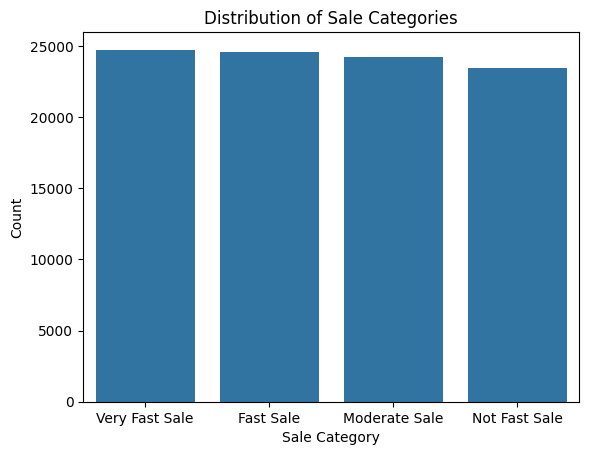

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = 'for_modeling.csv'  
df = pd.read_csv(file_path)

# Step 1: Calculate Percentiles
p25 = df['Duration'].quantile(0.25)  # 25th percentile
p50 = df['Duration'].quantile(0.50)  # 50th percentile (median)
p75 = df['Duration'].quantile(0.75)  # 75th percentile

print(f"25th Percentile: {p25}, 50th Percentile: {p50}, 75th Percentile: {p75}")

# Step 2: Define Sale Categories
bins = [0, p25, p50, p75, float('inf')]
labels = ['Very Fast Sale', 'Fast Sale', 'Moderate Sale', 'Not Fast Sale']
df['Sale Category'] = pd.cut(df['Duration'], bins=bins, labels=labels, right=True)

# Step 3: Check the Distribution of Sale Categories
print("Sale Category Distribution:")
print(df['Sale Category'].value_counts(normalize=True))  # Proportions for balance

# Step 4: Visualize the Distribution of Categories
sns.countplot(x='Sale Category', data=df, order=labels)
plt.title('Distribution of Sale Categories')
plt.xlabel('Sale Category')
plt.ylabel('Count')
plt.show()

# Step 5: (Optional) Save the Updated DataFrame
output_path = 'updated_data_with_categories.csv'
df.to_csv(output_path, index=False)


### Classification Model - Model 1 
To classify a FAST SALE 
We use quantile

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Define Features and Target
# Drop irrelevant columns and set up features and target
features_to_drop = ['Title','Currency', 'Seller','Item ID', 'Start Date', 'Start Hour', 'End Date', 'End Hour', 'Duration', 'Sale Category']
X = df.drop(columns=features_to_drop)
y = df['Sale Category']  # Target variable

# Step 2: Preprocess Categorical Variables
# Identify categorical columns
categorical_cols = ['Condition', 'Category', 'Shipping Type','Image Dimensions (Pixels)', 'Listing Type']  # Adjust as needed

# Apply one-hot encoding to categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Fixed parameter name
X_encoded = encoder.fit_transform(X[categorical_cols])

# Convert one-hot encoded columns to a DataFrame
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols)

# Drop original categorical columns and combine with the encoded DataFrame
X = X.drop(columns=categorical_cols)
X = pd.concat([X.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

# Step 3: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train the Model with Regularization
model1 = RandomForestClassifier(
    n_estimators=250,       # Increase number of trees
    max_depth=25,           # Allow deeper trees
    min_samples_split=4,    # Less restrictive splitting
    min_samples_leaf=2,     # Smaller leaf nodes
    random_state=42
)


# Train the model on the training data
model1.fit(X_train, y_train)


# Step 5: Evaluate the Model
# Predict on the test data
y_pred = model1.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model 1 Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model1.classes_, yticklabels=model1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importances (Optional)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model1.feature_importances_})
print("\nTop 10 Feature Importances:\n", feature_importances.sort_values(by='Importance', ascending=False).head(10))


In [ ]:
# Training set predictions and metrics
y_train_pred = model1.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test set predictions and metrics
y_test_pred = model1.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Loading dataset...
Categorizing 'Duration' into 'Sale Category'...
   Duration   Sale Category
0     745.0       Fast Sale
1     745.0       Fast Sale
2     745.0       Fast Sale
3     721.0  Very Fast Sale
4   10993.0   Not Fast Sale
Encoding 'Sale Category'...
Class Mapping: {'Fast Sale': 0, 'Moderate Sale': 1, 'Not Fast Sale': 2, 'Very Fast Sale': 3}
Defining features...
Encoding categorical variables...
Splitting 'Image Dimensions (Pixels)' into width and height...
Splitting data into training and test sets...
Training XGBoost model...
Model training complete.
Evaluating the model...
XGBoost Accuracy: 0.640736158366842

Classification Report:
                 precision    recall  f1-score   support

     Fast Sale       0.74      0.42      0.53      4979
 Moderate Sale       0.53      0.64      0.58      4843
 Not Fast Sale       0.63      0.72      0.67      4757
Very Fast Sale       0.72      0.79      0.76      4819

      accuracy                           0.64     19398
     m

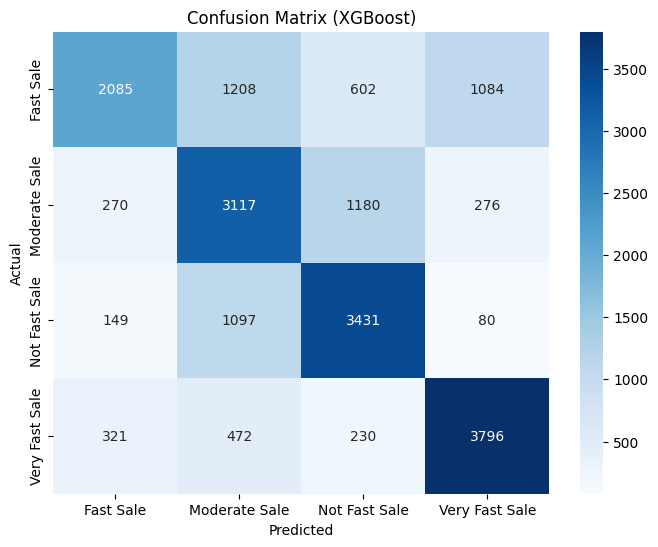


Decoded Predictions (Sample): ['Very Fast Sale' 'Very Fast Sale' 'Moderate Sale' 'Fast Sale'
 'Not Fast Sale' 'Very Fast Sale' 'Very Fast Sale' 'Very Fast Sale'
 'Not Fast Sale' 'Not Fast Sale']


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Step 1: Load the Dataset
print("Loading dataset...")
file_path = 'for_modeling.csv' 
df = pd.read_csv(file_path)

# Step 2: Categorize `Duration` into `Sale Category`
print("Categorizing 'Duration' into 'Sale Category'...")
q1, q2, q3 = df['Duration'].quantile([0.25, 0.50, 0.75])

def categorize_duration(duration):
    if duration <= q1:
        return 'Very Fast Sale'
    elif duration <= q2:
        return 'Fast Sale'
    elif duration <= q3:
        return 'Moderate Sale'
    else:
        return 'Not Fast Sale'

df['Sale Category'] = df['Duration'].apply(categorize_duration)
print(df[['Duration', 'Sale Category']].head())

# Step 3: Encode the Target Variable
print("Encoding 'Sale Category'...")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sale Category'])
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

# Step 4: Define Features
print("Defining features...")
features_to_drop = ['Title', 'Item ID', 'Start Date', 'Start Hour', 'End Date', 'End Hour', 'Duration', 'Sale Category']
X = df.drop(columns=features_to_drop)

# One-hot encode categorical variables
print("Encoding categorical variables...")
categorical_cols = ['Condition', 'Category', 'Shipping Type', 'Listing Type', 'Currency', 'Seller']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Handle 'Image Dimensions (Pixels)'
print("Splitting 'Image Dimensions (Pixels)' into width and height...")
X[['Image Width', 'Image Height']] = X['Image Dimensions (Pixels)'].str.split('x', expand=True).astype(float)
X = X.drop(columns=['Image Dimensions (Pixels)'])

# Step 5: Split the Data
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train the XGBoost Model
print("Training XGBoost model...")
model_xgb = XGBClassifier(
    n_estimators=100,        # Number of boosting rounds
    max_depth=6,             # Maximum depth of trees
    learning_rate=0.1,       # Learning rate
    subsample=0.8,           # Fraction of samples used per tree
    colsample_bytree=0.8,    # Fraction of features used per tree
    random_state=42
)

model_xgb.fit(X_train, y_train)
print("Model training complete.")

# Step 7: Evaluate the Model
print("Evaluating the model...")
y_pred = model_xgb.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
print("Generating confusion matrix...")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# Step 8: Optional - Decode Predictions for Interpretation
decoded_preds = label_encoder.inverse_transform(y_pred)
print("\nDecoded Predictions (Sample):", decoded_preds[:10])


In [8]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate on Training Data
y_train_pred = model_xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Evaluate on Test Data
y_test_pred = model_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Optional: Print Classification Reports for more details
print("\nClassification Report (Training):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Testing):")
print(classification_report(y_test, y_test_pred))


Training Accuracy: 0.6534907399054014
Test Accuracy: 0.640736158366842

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.74      0.42      0.53     19614
           1       0.55      0.67      0.60     19353
           2       0.64      0.73      0.68     18709
           3       0.74      0.79      0.77     19915

    accuracy                           0.65     77591
   macro avg       0.67      0.65      0.65     77591
weighted avg       0.67      0.65      0.65     77591


Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.74      0.42      0.53      4979
           1       0.53      0.64      0.58      4843
           2       0.63      0.72      0.67      4757
           3       0.72      0.79      0.76      4819

    accuracy                           0.64     19398
   macro avg       0.66      0.64      0.64     19398
weighted avg       0.66      0.64      0.63  

In [37]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# XGBoost model with regularization and tuned parameters
model_xgb = XGBClassifier(
    n_estimators=300,  # Number of trees
    max_depth=4,       # Reduced depth
    learning_rate=0.05,  # Slower learning
    subsample=0.8,     # Use 80% of the data for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    reg_alpha=1,       # L1 regularization
    reg_lambda=1,      # L2 regularization
    random_state=42
)

# Train the model
model_xgb.fit(X_train, y_train)

# Evaluate on Training Data
y_train_pred = model_xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Evaluate on Test Data
y_test_pred = model_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification report
print("\nClassification Report (Training):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Testing):")
print(classification_report(y_test, y_test_pred))
##

Training Accuracy: 0.6324058202626593
Test Accuracy: 0.62465202598206

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.71      0.39      0.51     19614
           1       0.54      0.62      0.58     19353
           2       0.61      0.73      0.66     18709
           3       0.72      0.79      0.75     19915

    accuracy                           0.63     77591
   macro avg       0.64      0.63      0.62     77591
weighted avg       0.64      0.63      0.62     77591


Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.72      0.40      0.52      4979
           1       0.53      0.61      0.56      4843
           2       0.60      0.72      0.65      4757
           3       0.70      0.78      0.74      4819

    accuracy                           0.62     19398
   macro avg       0.64      0.63      0.62     19398
weighted avg       0.64      0.62      0.62   

### Observations : 
## Showed poor performance on moderate sale 
## Thoughts : Try limiting the class into two FAST AND NOT FAST SALE


Training Set - SEEN DATA 

Class 0 (e.g., "Fast Sale"):

Precision: 0.74 – The model is relatively good at avoiding false positives for this class.
Recall: 0.42 – The model misses more than half of the actual "Fast Sale" items.
F1-Score: 0.53 – A moderate balance between precision and recall.
Class 1 (e.g., "Moderate Sale"):

Precision: 0.55 – The model is less precise here, with more false positives.
Recall: 0.67 – Better at capturing actual "Moderate Sale" items.
F1-Score: 0.60 – A slight improvement compared to Class 0.
Class 2 (e.g., "Not Fast Sale"):

Precision: 0.64 – Moderate precision, with some false positives.
Recall: 0.73 – Performs well at capturing "Not Fast Sale."
F1-Score: 0.68 – A good overall performance for this class.
Class 3 (e.g., "Very Fast Sale"):

Precision: 0.74 – High precision, fewer false positives.
Recall: 0.79 – Strong ability to detect "Very Fast Sale."
F1-Score: 0.77 – The best performance among all classes.
Accuracy (Training): 0.65

65% of all predictions were correct on the training set.
This is decent but shows that there’s room for improvement

Testing Set - Unseen data
Class 0 (e.g., "Fast Sale"):

Precision: 0.74 – Similar to training, relatively high precision.
Recall: 0.42 – The model struggles to capture many actual "Fast Sale" items.
F1-Score: 0.53 – Consistent with training performance.
Class 1 (e.g., "Moderate Sale"):

Precision: 0.53 – Slightly lower precision compared to training.
Recall: 0.64 – Performance has dropped slightly.
F1-Score: 0.58 – Slightly worse than in training.
Class 2 (e.g., "Not Fast Sale"):

Precision: 0.63 – Slight drop in precision.
Recall: 0.72 – Consistent with training.
F1-Score: 0.67 – Similar to training.
Class 3 (e.g., "Very Fast Sale"):

Precision: 0.72 – Still good precision but slightly lower than training.
Recall: 0.79 – Consistent with training.
F1-Score: 0.76 – Strong performance.
Accuracy (Testing): 0.64

64% of predictions were correct on the testing set.
The drop from 65% (training) to 64% (testing) suggests OVERFITTING.

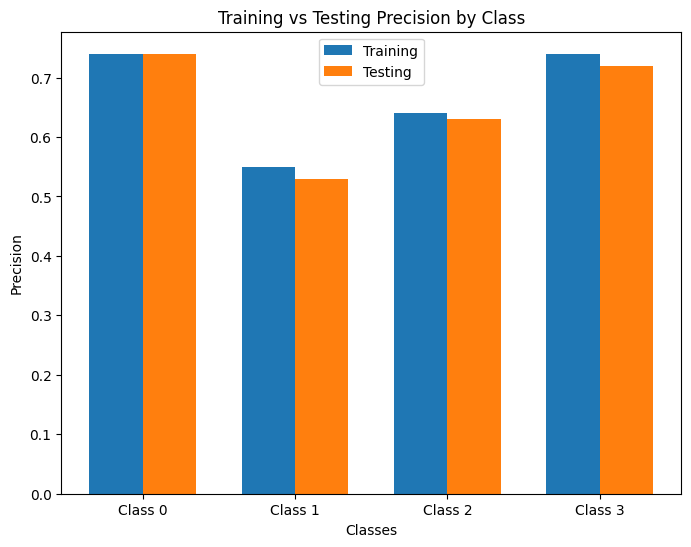

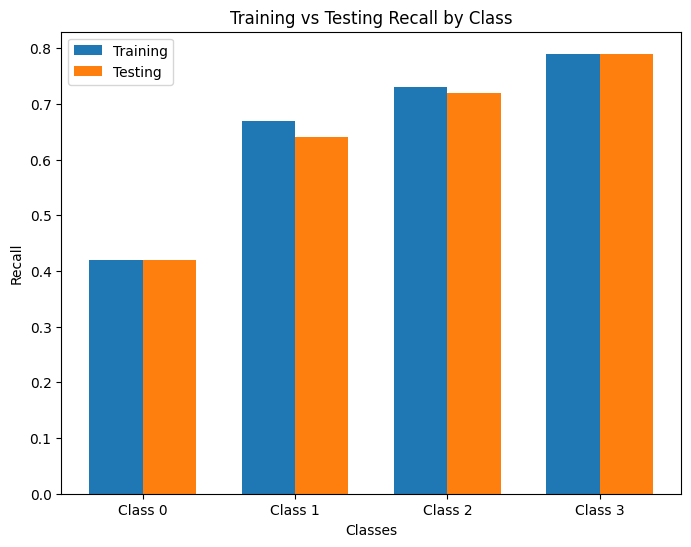

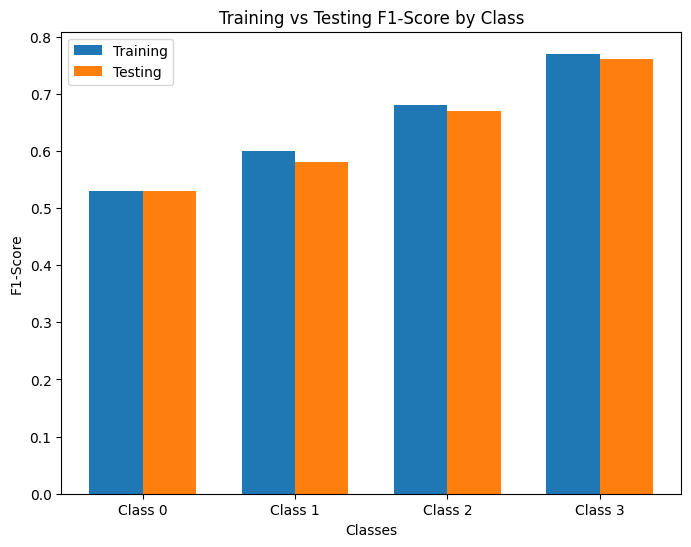

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your classification report (training and testing)
# Adjust these values to your actual data
metrics = ['Precision', 'Recall', 'F1-Score']

# Training metrics for each class
training_metrics = {
    'Precision': [0.74, 0.55, 0.64, 0.74],  # Example values for training precision
    'Recall': [0.42, 0.67, 0.73, 0.79],     # Example values for training recall
    'F1-Score': [0.53, 0.60, 0.68, 0.77]    # Example values for training F1-score
}

# Testing metrics for each class
testing_metrics = {
    'Precision': [0.74, 0.53, 0.63, 0.72],  # Example values for testing precision
    'Recall': [0.42, 0.64, 0.72, 0.79],     # Example values for testing recall
    'F1-Score': [0.53, 0.58, 0.67, 0.76]    # Example values for testing F1-score
}

# Plot comparison for each metric
for metric in metrics:
    x = np.arange(len(training_metrics[metric]))  # Class indices
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x - width/2, training_metrics[metric], width, label='Training')
    ax.bar(x + width/2, testing_metrics[metric], width, label='Testing')

    # Add labels and title
    ax.set_xlabel('Classes')
    ax.set_ylabel(metric)
    ax.set_title(f'Training vs Testing {metric} by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])  # Adjust class labels as needed
    ax.legend()

    plt.show()


In [2]:

# Load the dataset
data = pd.read_csv('for_modeling.csv')

# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlations
correlation = numerical_data.corr()  # Calculate pairwise correlations between numerical features

# Sort correlations with target ('Duration') and display
correlations_with_target = correlation['Duration'].sort_values(ascending=False)

# Split into positive and negative correlations
positive_correlation = correlations_with_target[correlations_with_target > 0]
negative_correlation = correlations_with_target[correlations_with_target < 0]

# Display the results
print("Positive Correlations with Duration:")
print(positive_correlation)

print("\nNegative Correlations with Duration:")
print(negative_correlation)


Positive Correlations with Duration:
Duration               1.000000
Feedback Score         0.156586
Shipping Cost          0.068267
Positive Feedback %    0.045029
Name: Duration, dtype: float64

Negative Correlations with Duration:
Price     -0.057122
Item ID   -0.131260
Name: Duration, dtype: float64


Positive Correlations
These features have a direct relationship with Duration. As their values increase, Duration tends to increase.

Feedback Score (0.156586):

Items from sellers with higher feedback scores tend to have slightly longer durations before selling.
This might indicate that sellers with a high reputation may list items at higher prices or for longer durations, leading to slower sales.
Shipping Cost (0.068267):

Higher shipping costs correlate with longer durations.
Buyers might be less willing to purchase items with high shipping costs, resulting in longer listing durations.
Positive Feedback % (0.045029):

A slight positive correlation suggests that sellers with a higher positive feedback percentage may experience slightly longer durations.
This could relate to the behavior of top-rated sellers listing items at premium prices or less-urgent sales.

 Negative Correlations
These features have an inverse relationship with Duration. As their values increase, Duration tends to decrease.

Price (-0.057122):

Items with lower prices tend to sell faster.
This aligns with buyer behavior, where cheaper items are more attractive and sell more quickly.

In [4]:
# Load the dataset
data = pd.read_csv('for_modeling.csv')

# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate correlations
correlation = numerical_data.corr()  # Calculate pairwise correlations between numerical features

# Sort correlations with target ('Duration') and display
correlations_with_target = correlation['Duration'].sort_values(ascending=False)

# Split into positive and negative correlations
positive_correlation = correlations_with_target[correlations_with_target > 0]
negative_correlation = correlations_with_target[correlations_with_target < 0]

# Display the results
print("Positive Correlations with Duration:")
print(positive_correlation)

print("\nNegative Correlations with Duration:")
print(negative_correlation)


Positive Correlations with Duration:
Duration               1.000000
Feedback Score         0.156586
Shipping Cost          0.068267
Positive Feedback %    0.045029
Name: Duration, dtype: float64

Negative Correlations with Duration:
Price     -0.057122
Item ID   -0.131260
Name: Duration, dtype: float64
